In [1]:
import torch

import torch.nn as nn

import torch.nn.functional as F

import torchvision

import torchvision.transforms as transforms

from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt

import pandas as pd

import numpy as np

import math

import time

In [2]:
torch.cuda.is_available()

True

Mapping files: 100%|█████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 68.22it/s]


The proportion of 0's in the genomic dataset is 33.34 %
The proportion of 1's in the genomic dataset is 33.34 %
The proportion of 2's in the genomic dataset is 33.32 %
The proportion of NaN's in the genomic dataset is 0.00 %
The proportion of having gout is 0.41


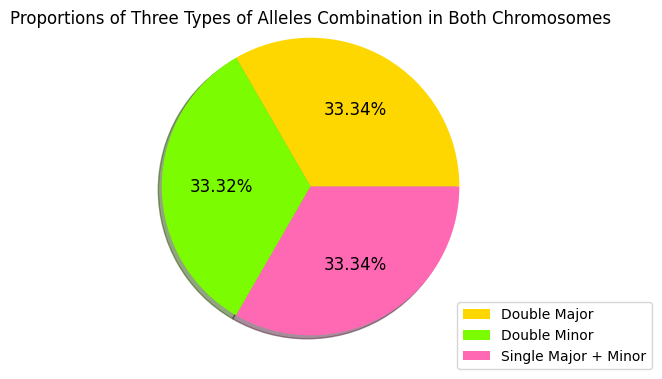

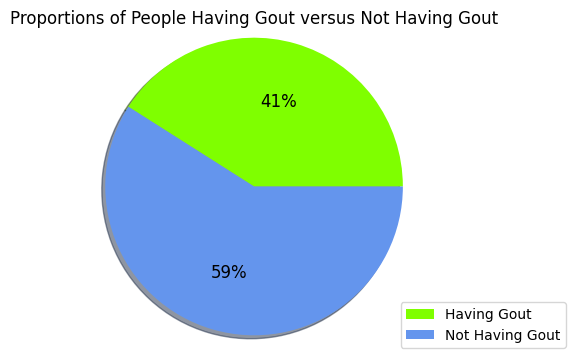

Mapping files: 100%|█████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 73.19it/s]
C:\Users\tuanh\AppData\Local\Temp\ipykernel_148\2141829978.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['encoded_sex'] = np.select([df['sex'] == "Male" , df['sex'] == "Female"], [1, 2])
C:\Users\tuanh\AppData\Local\Temp\ipykernel_148\2141829978.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)
  phenos_tensor = torch.Tensor(list(df.values))
C:\Users\tuanh\AppData\Local\Temp\ipyk

In [3]:
%run Data_Processing.ipynb

## Fully Connected FeedForward Neural Network Layer

In [4]:
class FFNLayer(nn.Module):
    
    def __init__(self, hidden_size_1, hidden_size_2, output_size):
        
        super().__init__()
        
        self.layer1 = nn.LazyLinear(hidden_size_1)
        
        self.layer2 = nn.LazyLinear(hidden_size_2)
        
        self.layer3 = nn.LazyLinear(output_size)
        
    def forward(self, inputs):
        
        first_outputs = F.gelu(self.layer1(inputs))
        
        second_outputs = F.gelu(self.layer2(first_outputs))
        
        final_outputs = self.layer3(second_outputs)
        
        return final_outputs

In [5]:
class NeuralNetwork(nn.Module):
    
    def __init__(self, hidden_size_1, hidden_size_2):
        
        super().__init__()
        
        self.softmax = nn.Softmax(dim=1)
        
        self.ffn = FFNLayer(hidden_size_1, hidden_size_2, 2)
        
    def forward(self, inputs):
            
        inputs = inputs.reshape(inputs.shape[0], -1)
            
        # outputs = F.relu(inputs)
        
        outputs_ffn = F.gelu(self.ffn(inputs))
        
        outputs_final = self.softmax(outputs_ffn)
              
        return outputs_final

## One Hot Encoding of the tokenised SNV data

In [6]:
class One_Hot_Encoding(nn.Module):
    
    def __init__(self, num_classes: int):
        
        super().__init__()
        
        self.num_classes = num_classes
        
    def forward(self, input_ts):
        
        return F.one_hot(input_ts.long(), num_classes = self.num_classes)

## Positional Encoding

In [7]:
class Positional_Encoding(nn.Module):
    
    def __init__(self, pos_dim, dropout):
        
        super().__init__()
        
        self.dropout = nn.Dropout(dropout)
        
        self.pos_dim = pos_dim
        
    def forward(self, input_ts):
        
        num_len = input_ts.shape[1]
        
        #num_dim = input_ts.shape[2]
        
        P = torch.zeros(1, num_len, self.pos_dim)
        
        X = (torch.arange(num_len, dtype=torch.float32).reshape(-1, 1) / 
        torch.pow(10000, torch.arange(0, self.pos_dim, 2, dtype = torch.float32) / self.pos_dim))
        
        P[:, :, 0::2] = torch.sin(X)
        
        if (self.pos_dim % 2) == 1:
            
            P[:, :, 1::2] = torch.cos(X[:, :-1])
            
        else:    
            
            P[:, :, 1::2] = torch.cos(X)
        
        P = torch.repeat_interleave(P, repeats = input_ts.shape[0], dim = 0)
        
        return self.dropout(P[:, :input_ts.shape[1], :].to(input_ts.device))

## Processing the raw datasets

In [8]:
class prepare_dataset(nn.Module):
    
    def __init__(self, num_classes: int, phenos_or_not: bool, pos_dim: int, dropout):
        
        super().__init__()
        
        self.one_hot_encoding = One_Hot_Encoding(num_classes)
        
        self.positional_encoding = Positional_Encoding(pos_dim, dropout)
        
        self.num_classes = num_classes
        
        self.phenos_or_not = phenos_or_not
        
    def forward(self, snv_ts, phenos_ts):
        
        # Process tokenised SNV data
        
        encoded_snv_ts = self.one_hot_encoding(snv_ts)
        
        pos_encoded_snv_ts = self.positional_encoding(encoded_snv_ts)
        
        if self.phenos_or_not:
            
            # Process phenotypes data
            
            phenos_ts = phenos_ts.unsqueeze(0)
            
            phenos_ts = torch.repeat_interleave(phenos_ts, repeats = snv_ts.shape[1], dim = 1)
            
            phenos_ts = phenos_ts.reshape(-1, snv_ts.shape[1], phenos_ts.shape[2])
            
            # Join encoded SNV and phenotypes datasets
            
            complete_ts = torch.cat((encoded_snv_ts, pos_encoded_snv_ts, phenos_ts), dim = 2)
            
        else:
            
            #complete_ts = torch.cat((encoded_snv_ts, pos_encoded_snv_ts), dim = 2)
            
            #complete_ts = snv_ts.to(torch.float32)
            
            complete_ts = encoded_snv_ts.to(torch.float32)
            
        return complete_ts
            

In [9]:
pros = prepare_dataset(num_classes = 3, phenos_or_not = False, pos_dim = 3, dropout = 0.0)

In [10]:
train_df = pros(tr_snv, tr_phenos)

In [11]:
train_df.shape

torch.Size([6999, 2000, 3])

In [12]:
test_df = pros(te_snv, te_phenos)

In [13]:
test_df.shape

torch.Size([2500, 2000, 3])

In [14]:
tr_gout.shape

torch.Size([6999])

In [15]:
te_gout.shape

torch.Size([2500])

In [16]:
# Merge data and labels

train_ts = TensorDataset(train_df, tr_gout)

test_ts = TensorDataset(test_df, te_gout)

In [17]:
# Loading training and testing datasets

train_dataloader = DataLoader(train_ts, batch_size = 10, shuffle = True)

#label_tr_dataloader = torch.utils.data.DataLoader(tr_gout, batch_size = 10, shuffle = False)

test_dataloader = DataLoader(test_ts, batch_size = 5, shuffle = False)

#label_te_dataloader = torch.utils.data.DataLoader(te_gout, batch_size = 4, shuffle = False)

In [18]:
epoch_list = np.around(np.arange(0 + 1/3, 25 + 1/3, 1/3), 1)

loss_values_4 = np.repeat(0, 75)

loss_values_8 = np.repeat(0, 75)

loss_values_16 = np.repeat(0, 75)

loss_values_32 = np.repeat(0, 75)

loss_values_64 = np.repeat(0, 75)

loss_values_128 = np.repeat(0, 75)

loss_values_256 = np.repeat(0, 75)

In [19]:
epoch_df = pd.DataFrame({'epoch_value': epoch_list, 'loss_value_4': loss_values_4,
                         'loss_value_8': loss_values_8, 'loss_value_16': loss_values_16,
                        'loss_values_32': loss_values_32, 'loss_value_64': loss_values_64,
                        'loss_values_128': loss_values_128, 'loss_values_256': loss_values_256})

In [20]:
overall_accuracy = np.repeat(0, 7)

accuracy_not_gout = np.repeat(0, 7)

accuracy_gout = np.repeat(0, 7)

precision_not_gout = np.repeat(0, 7)

precision_gout = np.repeat(0, 7)

training_time = np.repeat(0, 7)

In [21]:
result_df = pd.DataFrame({'overall_accuracy': overall_accuracy, 'accuracy_not_gout': accuracy_not_gout,
                         'accuracy_gout': accuracy_gout, 'precision_not_gout': precision_not_gout,
                        'precision_gout': precision_gout, 'training_time': training_time})

In [22]:
result_df.index = ['hidden_size_4', 'hidden_size_8', 'hidden_size_16', 'hidden_size_32', 
                   'hidden_size_64', 'hidden_size_128', 'hidden_size_256']

## Hidden Layer Size = 4

In [23]:
model = NeuralNetwork(hidden_size_1 = 4, hidden_size_2 = 4)

C:\Users\tuanh\anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [24]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5, amsgrad = True)

epochs = 25

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
model = model.to(device)

In [26]:
n_total_steps = len(train_dataloader)

In [27]:
start_time = time.time()

In [28]:
loss_count = 0

model.train()

for epoch in range(epochs):
    
    for i, (seqs, labels) in enumerate(train_dataloader):
        
        #labels = torch.unsqueeze(labels, 1)
        
        #seqs = torch.unsqueeze(seqs, 1)
        
        seqs = seqs.to(device)
        
        labels = labels.to(device)
        
        outputs = model(seqs)
        
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        if (i+1) % 200 == 0:
            
            print (f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.3f}')
            
            epoch_df.iloc[loss_count, 1] = round(loss.item(), 2)
            
            loss_count += 1

Epoch [1/25], Step [200/700], Loss: 0.702
Epoch [1/25], Step [400/700], Loss: 0.640
Epoch [1/25], Step [600/700], Loss: 0.676
Epoch [2/25], Step [200/700], Loss: 0.705
Epoch [2/25], Step [400/700], Loss: 0.602
Epoch [2/25], Step [600/700], Loss: 0.666
Epoch [3/25], Step [200/700], Loss: 0.778
Epoch [3/25], Step [400/700], Loss: 0.649
Epoch [3/25], Step [600/700], Loss: 0.681
Epoch [4/25], Step [200/700], Loss: 0.704
Epoch [4/25], Step [400/700], Loss: 0.699
Epoch [4/25], Step [600/700], Loss: 0.672
Epoch [5/25], Step [200/700], Loss: 0.602
Epoch [5/25], Step [400/700], Loss: 0.694
Epoch [5/25], Step [600/700], Loss: 0.594
Epoch [6/25], Step [200/700], Loss: 0.729
Epoch [6/25], Step [400/700], Loss: 0.636
Epoch [6/25], Step [600/700], Loss: 0.697
Epoch [7/25], Step [200/700], Loss: 0.626
Epoch [7/25], Step [400/700], Loss: 0.622
Epoch [7/25], Step [600/700], Loss: 0.695
Epoch [8/25], Step [200/700], Loss: 0.607
Epoch [8/25], Step [400/700], Loss: 0.725
Epoch [8/25], Step [600/700], Loss

In [29]:
print("%s seconds" % round((time.time() - start_time),2))

result_df.iloc[0, 5] = round((time.time() - start_time),2)

52.49 seconds


In [30]:
classes = ('0', '1')

In [31]:
model.eval()

# Evaluate the trained model performance

with torch.no_grad():
    
    batch_size = 5
    
    num_correct_preds = 0
    
    num_total = len(test_df)
    
    num_correct_per_label = [0] * len(classes)
    
    num_total_per_label = [0] * len(classes)
    
    num_preds_per_label = [0] * len(classes)
    
    for i, (seqs, labels) in enumerate(test_dataloader):
        
        #seqs = torch.unsqueeze(seqs, 1)
        
        seqs = seqs.to(device)
        
        labels = labels.to(device)
        
        outputs = model(seqs)
        
        # Return the value with the highest probability score
        
        _, pred_values = torch.max(outputs, 1)
        
        num_correct_preds += (pred_values == labels).sum().item()        
    
        for i in range(batch_size):
            
            label = labels[i]
            
            pred_val = pred_values[i]
            
            #print(pred_values)
            
            num_total_per_label[label] += 1
            
            num_preds_per_label[pred_val] += 1
            
            if label == pred_val:
                
                num_correct_per_label[label] += 1
                
    # Calculate Overall Accuracy
    
    overall_accuracy = 100.0 * num_correct_preds / num_total
    
    print(f'Overall accuracy of the model: {overall_accuracy:.3f} %')
    
    result_df.iloc[0, 0] = round(overall_accuracy, 3)
    
    # Calculate Accuracy per Label
    
    for i in range(len(classes)):
        
        accuracy_per_label = 100.0 * num_correct_per_label[i] / num_total_per_label[i]
        
        precision_per_label = 100.0 * num_correct_per_label[i] / num_preds_per_label[i]
        
        print(f'Accuracy of Label {classes[i]} : {accuracy_per_label:.3f} %')
        
        result_df.iloc[0, i+1] = round(accuracy_per_label, 3) 
        
        print(f'Precision of Label {classes[i]} : {precision_per_label:.3f} %')
        
        result_df.iloc[0, i+3] = round(precision_per_label, 3)


Overall accuracy of the model: 58.880 %
Accuracy of Label 0 : 99.727 %
Precision of Label 0 : 58.760 %
Accuracy of Label 1 : 1.254 %
Precision of Label 1 : 76.471 %


## Hidden Layer Size = 8

In [32]:
model = NeuralNetwork(hidden_size_1 = 8, hidden_size_2 = 8)

In [33]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5, amsgrad = True)

epochs = 25

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [34]:
model = model.to(device)

In [35]:
start_time = time.time()

In [36]:
loss_count = 0

model.train()

for epoch in range(epochs):
    
    for i, (seqs, labels) in enumerate(train_dataloader):
        
        #labels = torch.unsqueeze(labels, 1)
        
        #seqs = torch.unsqueeze(seqs, 1)
        
        seqs = seqs.to(device)
        
        labels = labels.to(device)
        
        outputs = model(seqs)
        
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        if (i+1) % 200 == 0:
            
            print (f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.3f}')
            
            epoch_df.iloc[loss_count, 2] = round(loss.item(), 2)
            
            loss_count += 1

Epoch [1/25], Step [200/700], Loss: 0.696
Epoch [1/25], Step [400/700], Loss: 0.691
Epoch [1/25], Step [600/700], Loss: 0.688
Epoch [2/25], Step [200/700], Loss: 0.679
Epoch [2/25], Step [400/700], Loss: 0.674
Epoch [2/25], Step [600/700], Loss: 0.672
Epoch [3/25], Step [200/700], Loss: 0.741
Epoch [3/25], Step [400/700], Loss: 0.672
Epoch [3/25], Step [600/700], Loss: 0.701
Epoch [4/25], Step [200/700], Loss: 0.701
Epoch [4/25], Step [400/700], Loss: 0.670
Epoch [4/25], Step [600/700], Loss: 0.678
Epoch [5/25], Step [200/700], Loss: 0.637
Epoch [5/25], Step [400/700], Loss: 0.724
Epoch [5/25], Step [600/700], Loss: 0.642
Epoch [6/25], Step [200/700], Loss: 0.597
Epoch [6/25], Step [400/700], Loss: 0.686
Epoch [6/25], Step [600/700], Loss: 0.656
Epoch [7/25], Step [200/700], Loss: 0.625
Epoch [7/25], Step [400/700], Loss: 0.700
Epoch [7/25], Step [600/700], Loss: 0.580
Epoch [8/25], Step [200/700], Loss: 0.650
Epoch [8/25], Step [400/700], Loss: 0.741
Epoch [8/25], Step [600/700], Loss

In [37]:
print("%s seconds" % round((time.time() - start_time),2))

result_df.iloc[1, 5] = round((time.time() - start_time),2)

49.5 seconds


In [38]:
model.eval()

# Evaluate the trained model performance

with torch.no_grad():
    
    batch_size = 5
    
    num_correct_preds = 0
    
    num_total = len(test_df)
    
    num_correct_per_label = [0] * len(classes)
    
    num_total_per_label = [0] * len(classes)
    
    num_preds_per_label = [0] * len(classes)
    
    for i, (seqs, labels) in enumerate(test_dataloader):
        
        #seqs = torch.unsqueeze(seqs, 1)
        
        seqs = seqs.to(device)
        
        labels = labels.to(device)
        
        outputs = model(seqs)
        
        # Return the value with the highest probability score
        
        _, pred_values = torch.max(outputs, 1)
        
        num_correct_preds += (pred_values == labels).sum().item()        
    
        for i in range(batch_size):
            
            label = labels[i]
            
            pred_val = pred_values[i]
            
            #print(pred_values)
            
            num_total_per_label[label] += 1
            
            num_preds_per_label[pred_val] += 1
            
            if label == pred_val:
                
                num_correct_per_label[label] += 1
                
    # Calculate Overall Accuracy
    
    overall_accuracy = 100.0 * num_correct_preds / num_total
    
    print(f'Overall accuracy of the model: {overall_accuracy:.3f} %')
    
    result_df.iloc[1, 0] = round(overall_accuracy, 3)
    
    # Calculate Accuracy per Label
    
    for i in range(len(classes)):
        
        accuracy_per_label = 100.0 * num_correct_per_label[i] / num_total_per_label[i]
        
        precision_per_label = 100.0 * num_correct_per_label[i] / num_preds_per_label[i]
        
        print(f'Accuracy of Label {classes[i]} : {accuracy_per_label:.3f} %')
        
        result_df.iloc[1, i+1] = round(accuracy_per_label, 3) 
        
        print(f'Precision of Label {classes[i]} : {precision_per_label:.3f} %')
        
        result_df.iloc[1, i+3] = round(precision_per_label, 3)


Overall accuracy of the model: 64.120 %
Accuracy of Label 0 : 88.722 %
Precision of Label 0 : 63.941 %
Accuracy of Label 1 : 29.412 %
Precision of Label 1 : 64.894 %


## Hidden Layer Size = 16

In [39]:
model = NeuralNetwork(hidden_size_1 = 16, hidden_size_2 = 16)

In [40]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5, amsgrad = True)

epochs = 25

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [41]:
model = model.to(device)

In [42]:
start_time = time.time()

In [43]:
loss_count = 0

model.train()

for epoch in range(epochs):
    
    for i, (seqs, labels) in enumerate(train_dataloader):
        
        #labels = torch.unsqueeze(labels, 1)
        
        #seqs = torch.unsqueeze(seqs, 1)
        
        seqs = seqs.to(device)
        
        labels = labels.to(device)
        
        outputs = model(seqs)
        
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        if (i+1) % 200 == 0:
            
            print (f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.3f}')
            
            epoch_df.iloc[loss_count, 3] = round(loss.item(), 2)
            
            loss_count += 1

Epoch [1/25], Step [200/700], Loss: 0.662
Epoch [1/25], Step [400/700], Loss: 0.652
Epoch [1/25], Step [600/700], Loss: 0.679
Epoch [2/25], Step [200/700], Loss: 0.676
Epoch [2/25], Step [400/700], Loss: 0.671
Epoch [2/25], Step [600/700], Loss: 0.610
Epoch [3/25], Step [200/700], Loss: 0.729
Epoch [3/25], Step [400/700], Loss: 0.729
Epoch [3/25], Step [600/700], Loss: 0.641
Epoch [4/25], Step [200/700], Loss: 0.702
Epoch [4/25], Step [400/700], Loss: 0.735
Epoch [4/25], Step [600/700], Loss: 0.718
Epoch [5/25], Step [200/700], Loss: 0.635
Epoch [5/25], Step [400/700], Loss: 0.662
Epoch [5/25], Step [600/700], Loss: 0.688
Epoch [6/25], Step [200/700], Loss: 0.638
Epoch [6/25], Step [400/700], Loss: 0.665
Epoch [6/25], Step [600/700], Loss: 0.643
Epoch [7/25], Step [200/700], Loss: 0.631
Epoch [7/25], Step [400/700], Loss: 0.755
Epoch [7/25], Step [600/700], Loss: 0.651
Epoch [8/25], Step [200/700], Loss: 0.653
Epoch [8/25], Step [400/700], Loss: 0.624
Epoch [8/25], Step [600/700], Loss

In [44]:
print("%s seconds" % round((time.time() - start_time), 2))

result_df.iloc[2, 5] = round((time.time() - start_time), 2)

49.82 seconds


In [45]:
model.eval()

# Evaluate the trained model performance

with torch.no_grad():
    
    batch_size = 5
    
    num_correct_preds = 0
    
    num_total = len(test_df)
    
    num_correct_per_label = [0] * len(classes)
    
    num_total_per_label = [0] * len(classes)
    
    num_preds_per_label = [0] * len(classes)
    
    for i, (seqs, labels) in enumerate(test_dataloader):
        
        #seqs = torch.unsqueeze(seqs, 1)
        
        seqs = seqs.to(device)
        
        labels = labels.to(device)
        
        outputs = model(seqs)
        
        # Return the value with the highest probability score
        
        _, pred_values = torch.max(outputs, 1)
        
        num_correct_preds += (pred_values == labels).sum().item()        
    
        for i in range(batch_size):
            
            label = labels[i]
            
            pred_val = pred_values[i]
            
            #print(pred_values)
            
            num_total_per_label[label] += 1
            
            num_preds_per_label[pred_val] += 1
            
            if label == pred_val:
                
                num_correct_per_label[label] += 1
                
    # Calculate Overall Accuracy
    
    overall_accuracy = 100.0 * num_correct_preds / num_total
    
    print(f'Overall accuracy of the model: {overall_accuracy:.3f} %')
    
    result_df.iloc[2, 0] = round(overall_accuracy, 3)
    
    # Calculate Accuracy per Label
    
    for i in range(len(classes)):
        
        accuracy_per_label = 100.0 * num_correct_per_label[i] / num_total_per_label[i]
        
        precision_per_label = 100.0 * num_correct_per_label[i] / num_preds_per_label[i]
        
        print(f'Accuracy of Label {classes[i]} : {accuracy_per_label:.3f} %')
        
        result_df.iloc[2, i+1] = round(accuracy_per_label, 3) 
        
        print(f'Precision of Label {classes[i]} : {precision_per_label:.3f} %')
        
        result_df.iloc[2, i+3] = round(precision_per_label, 3)


Overall accuracy of the model: 64.600 %
Accuracy of Label 0 : 84.074 %
Precision of Label 0 : 65.356 %
Accuracy of Label 1 : 37.126 %
Precision of Label 1 : 62.298 %


## Hidden Layer Size = 32

In [46]:
model = NeuralNetwork(hidden_size_1 = 32, hidden_size_2 = 32)

In [47]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5, amsgrad = True)

epochs = 25

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [48]:
model = model.to(device)

In [49]:
start_time = time.time()

In [50]:
loss_count = 0

model.train()

for epoch in range(epochs):
    
    for i, (seqs, labels) in enumerate(train_dataloader):
        
        #labels = torch.unsqueeze(labels, 1)
        
        #seqs = torch.unsqueeze(seqs, 1)
        
        seqs = seqs.to(device)
        
        labels = labels.to(device)
        
        outputs = model(seqs)
        
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        if (i+1) % 200 == 0:
            
            print (f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.3f}')
            
            epoch_df.iloc[loss_count, 4] = round(loss.item(), 2)
            
            loss_count += 1

Epoch [1/25], Step [200/700], Loss: 0.692
Epoch [1/25], Step [400/700], Loss: 0.666
Epoch [1/25], Step [600/700], Loss: 0.646
Epoch [2/25], Step [200/700], Loss: 0.670
Epoch [2/25], Step [400/700], Loss: 0.648
Epoch [2/25], Step [600/700], Loss: 0.671
Epoch [3/25], Step [200/700], Loss: 0.700
Epoch [3/25], Step [400/700], Loss: 0.667
Epoch [3/25], Step [600/700], Loss: 0.696
Epoch [4/25], Step [200/700], Loss: 0.720
Epoch [4/25], Step [400/700], Loss: 0.626
Epoch [4/25], Step [600/700], Loss: 0.671
Epoch [5/25], Step [200/700], Loss: 0.654
Epoch [5/25], Step [400/700], Loss: 0.676
Epoch [5/25], Step [600/700], Loss: 0.637
Epoch [6/25], Step [200/700], Loss: 0.704
Epoch [6/25], Step [400/700], Loss: 0.642
Epoch [6/25], Step [600/700], Loss: 0.649
Epoch [7/25], Step [200/700], Loss: 0.619
Epoch [7/25], Step [400/700], Loss: 0.609
Epoch [7/25], Step [600/700], Loss: 0.588
Epoch [8/25], Step [200/700], Loss: 0.599
Epoch [8/25], Step [400/700], Loss: 0.643
Epoch [8/25], Step [600/700], Loss

In [51]:
print("%s seconds" % round((time.time() - start_time), 2))

result_df.iloc[3, 5] = round((time.time() - start_time), 2)

58.4 seconds


In [52]:
model.eval()

# Evaluate the trained model performance

with torch.no_grad():
    
    batch_size = 5
    
    num_correct_preds = 0
    
    num_total = len(test_df)
    
    num_correct_per_label = [0] * len(classes)
    
    num_total_per_label = [0] * len(classes)
    
    num_preds_per_label = [0] * len(classes)
    
    for i, (seqs, labels) in enumerate(test_dataloader):
        
        #seqs = torch.unsqueeze(seqs, 1)
        
        seqs = seqs.to(device)
        
        labels = labels.to(device)
        
        outputs = model(seqs)
        
        # Return the value with the highest probability score
        
        _, pred_values = torch.max(outputs, 1)
        
        num_correct_preds += (pred_values == labels).sum().item()        
    
        for i in range(batch_size):
            
            label = labels[i]
            
            pred_val = pred_values[i]
            
            #print(pred_values)
            
            num_total_per_label[label] += 1
            
            num_preds_per_label[pred_val] += 1
            
            if label == pred_val:
                
                num_correct_per_label[label] += 1
                
    # Calculate Overall Accuracy
    
    overall_accuracy = 100.0 * num_correct_preds / num_total
    
    print(f'Overall accuracy of the model: {overall_accuracy:.3f} %')
    
    result_df.iloc[3, 0] = round(overall_accuracy, 3)
    
    # Calculate Accuracy per Label
    
    for i in range(len(classes)):
        
        accuracy_per_label = 100.0 * num_correct_per_label[i] / num_total_per_label[i]
        
        precision_per_label = 100.0 * num_correct_per_label[i] / num_preds_per_label[i]
        
        print(f'Accuracy of Label {classes[i]} : {accuracy_per_label:.3f} %')
        
        result_df.iloc[3, i+1] = round(accuracy_per_label, 3) 
        
        print(f'Precision of Label {classes[i]} : {precision_per_label:.3f} %')
        
        result_df.iloc[3, i+3] = round(precision_per_label, 3)


Overall accuracy of the model: 66.840 %
Accuracy of Label 0 : 74.163 %
Precision of Label 0 : 70.638 %
Accuracy of Label 1 : 56.509 %
Precision of Label 1 : 60.788 %


## Hidden Layer Size = 64

In [53]:
model = NeuralNetwork(hidden_size_1 = 64, hidden_size_2 = 64)

In [54]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5, amsgrad = True)

epochs = 25

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [55]:
model = model.to(device)

In [56]:
start_time = time.time()

In [57]:
loss_count = 0

model.train()

for epoch in range(epochs):
    
    for i, (seqs, labels) in enumerate(train_dataloader):
        
        #labels = torch.unsqueeze(labels, 1)
        
        #seqs = torch.unsqueeze(seqs, 1)
        
        seqs = seqs.to(device)
        
        labels = labels.to(device)
        
        outputs = model(seqs)
        
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        if (i+1) % 200 == 0:
            
            print (f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.3f}')
            
            epoch_df.iloc[loss_count, 5] = round(loss.item(), 2)
            
            loss_count += 1

Epoch [1/25], Step [200/700], Loss: 0.678
Epoch [1/25], Step [400/700], Loss: 0.674
Epoch [1/25], Step [600/700], Loss: 0.748
Epoch [2/25], Step [200/700], Loss: 0.672
Epoch [2/25], Step [400/700], Loss: 0.762
Epoch [2/25], Step [600/700], Loss: 0.680
Epoch [3/25], Step [200/700], Loss: 0.693
Epoch [3/25], Step [400/700], Loss: 0.623
Epoch [3/25], Step [600/700], Loss: 0.638
Epoch [4/25], Step [200/700], Loss: 0.587
Epoch [4/25], Step [400/700], Loss: 0.659
Epoch [4/25], Step [600/700], Loss: 0.624
Epoch [5/25], Step [200/700], Loss: 0.707
Epoch [5/25], Step [400/700], Loss: 0.633
Epoch [5/25], Step [600/700], Loss: 0.621
Epoch [6/25], Step [200/700], Loss: 0.575
Epoch [6/25], Step [400/700], Loss: 0.657
Epoch [6/25], Step [600/700], Loss: 0.620
Epoch [7/25], Step [200/700], Loss: 0.626
Epoch [7/25], Step [400/700], Loss: 0.561
Epoch [7/25], Step [600/700], Loss: 0.616
Epoch [8/25], Step [200/700], Loss: 0.591
Epoch [8/25], Step [400/700], Loss: 0.576
Epoch [8/25], Step [600/700], Loss

In [58]:
print("%s seconds" % round((time.time() - start_time),2))

result_df.iloc[4, 5] = round((time.time() - start_time), 2)

57.15 seconds


In [59]:
model.eval()

# Evaluate the trained model performance

with torch.no_grad():
    
    batch_size = 5
    
    num_correct_preds = 0
    
    num_total = len(test_df)
    
    num_correct_per_label = [0] * len(classes)
    
    num_total_per_label = [0] * len(classes)
    
    num_preds_per_label = [0] * len(classes)
    
    for i, (seqs, labels) in enumerate(test_dataloader):
        
        #seqs = torch.unsqueeze(seqs, 1)
        
        seqs = seqs.to(device)
        
        labels = labels.to(device)
        
        outputs = model(seqs)
        
        # Return the value with the highest probability score
        
        _, pred_values = torch.max(outputs, 1)
        
        num_correct_preds += (pred_values == labels).sum().item()        
    
        for i in range(batch_size):
            
            label = labels[i]
            
            pred_val = pred_values[i]
            
            #print(pred_values)
            
            num_total_per_label[label] += 1
            
            num_preds_per_label[pred_val] += 1
            
            if label == pred_val:
                
                num_correct_per_label[label] += 1
                
    # Calculate Overall Accuracy
    
    overall_accuracy = 100.0 * num_correct_preds / num_total
    
    print(f'Overall accuracy of the model: {overall_accuracy:.3f} %')
    
    result_df.iloc[4, 0] = round(overall_accuracy, 3)
    
    # Calculate Accuracy per Label
    
    for i in range(len(classes)):
        
        accuracy_per_label = 100.0 * num_correct_per_label[i] / num_total_per_label[i]
        
        precision_per_label = 100.0 * num_correct_per_label[i] / num_preds_per_label[i]
        
        print(f'Accuracy of Label {classes[i]} : {accuracy_per_label:.3f} %')
        
        result_df.iloc[4, i+1] = round(accuracy_per_label, 3) 
        
        print(f'Precision of Label {classes[i]} : {precision_per_label:.3f} %')
        
        result_df.iloc[4, i+3] = round(precision_per_label, 3)


Overall accuracy of the model: 66.600 %
Accuracy of Label 0 : 76.282 %
Precision of Label 0 : 69.576 %
Accuracy of Label 1 : 52.941 %
Precision of Label 1 : 61.272 %


## Hidden Layer Size = 128

In [60]:
model = NeuralNetwork(hidden_size_1 = 128, hidden_size_2 = 128)

In [61]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5, amsgrad = True)

epochs = 25

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [62]:
model = model.to(device)

In [63]:
start_time = time.time()

In [64]:
loss_count = 0

model.train()

for epoch in range(epochs):
    
    for i, (seqs, labels) in enumerate(train_dataloader):
        
        #labels = torch.unsqueeze(labels, 1)
        
        #seqs = torch.unsqueeze(seqs, 1)
        
        seqs = seqs.to(device)
        
        labels = labels.to(device)
        
        outputs = model(seqs)
        
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        if (i+1) % 200 == 0:
            
            print (f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.3f}')
            
            epoch_df.iloc[loss_count, 6] = round(loss.item(), 2)
            
            loss_count += 1

Epoch [1/25], Step [200/700], Loss: 0.618
Epoch [1/25], Step [400/700], Loss: 0.677
Epoch [1/25], Step [600/700], Loss: 0.642
Epoch [2/25], Step [200/700], Loss: 0.580
Epoch [2/25], Step [400/700], Loss: 0.667
Epoch [2/25], Step [600/700], Loss: 0.684
Epoch [3/25], Step [200/700], Loss: 0.737
Epoch [3/25], Step [400/700], Loss: 0.617
Epoch [3/25], Step [600/700], Loss: 0.644
Epoch [4/25], Step [200/700], Loss: 0.654
Epoch [4/25], Step [400/700], Loss: 0.613
Epoch [4/25], Step [600/700], Loss: 0.654
Epoch [5/25], Step [200/700], Loss: 0.587
Epoch [5/25], Step [400/700], Loss: 0.597
Epoch [5/25], Step [600/700], Loss: 0.514
Epoch [6/25], Step [200/700], Loss: 0.515
Epoch [6/25], Step [400/700], Loss: 0.525
Epoch [6/25], Step [600/700], Loss: 0.624
Epoch [7/25], Step [200/700], Loss: 0.579
Epoch [7/25], Step [400/700], Loss: 0.547
Epoch [7/25], Step [600/700], Loss: 0.554
Epoch [8/25], Step [200/700], Loss: 0.474
Epoch [8/25], Step [400/700], Loss: 0.477
Epoch [8/25], Step [600/700], Loss

In [65]:
print("%s seconds" % round((time.time() - start_time), 2))

result_df.iloc[5, 5] = round((time.time() - start_time), 2)

67.08 seconds


In [66]:
model.eval()

# Evaluate the trained model performance

with torch.no_grad():
    
    batch_size = 5
    
    num_correct_preds = 0
    
    num_total = len(test_df)
    
    num_correct_per_label = [0] * len(classes)
    
    num_total_per_label = [0] * len(classes)
    
    num_preds_per_label = [0] * len(classes)
    
    for i, (seqs, labels) in enumerate(test_dataloader):
        
        #seqs = torch.unsqueeze(seqs, 1)
        
        seqs = seqs.to(device)
        
        labels = labels.to(device)
        
        outputs = model(seqs)
        
        # Return the value with the highest probability score
        
        _, pred_values = torch.max(outputs, 1)
        
        num_correct_preds += (pred_values == labels).sum().item()        
    
        for i in range(batch_size):
            
            label = labels[i]
            
            pred_val = pred_values[i]
            
            #print(pred_values)
            
            num_total_per_label[label] += 1
            
            num_preds_per_label[pred_val] += 1
            
            if label == pred_val:
                
                num_correct_per_label[label] += 1
                
    # Calculate Overall Accuracy
    
    overall_accuracy = 100.0 * num_correct_preds / num_total
    
    print(f'Overall accuracy of the model: {overall_accuracy:.3f} %')
    
    result_df.iloc[5, 0] = round(overall_accuracy, 3)
    
    # Calculate Accuracy per Label
    
    for i in range(len(classes)):
        
        accuracy_per_label = 100.0 * num_correct_per_label[i] / num_total_per_label[i]
        
        precision_per_label = 100.0 * num_correct_per_label[i] / num_preds_per_label[i]
        
        print(f'Accuracy of Label {classes[i]} : {accuracy_per_label:.3f} %')
        
        result_df.iloc[5, i+1] = round(accuracy_per_label, 3) 
        
        print(f'Precision of Label {classes[i]} : {precision_per_label:.3f} %')
        
        result_df.iloc[5, i+3] = round(precision_per_label, 3)


Overall accuracy of the model: 66.960 %
Accuracy of Label 0 : 76.487 %
Precision of Label 0 : 69.894 %
Accuracy of Label 1 : 53.520 %
Precision of Label 1 : 61.735 %


## Hidden Layer Size = 256

In [67]:
model = NeuralNetwork(hidden_size_1 = 256, hidden_size_2 = 256)

In [68]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5, amsgrad = True)

epochs = 25

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [69]:
model = model.to(device)

In [70]:
start_time = time.time()

In [71]:
loss_count = 0

model.train()

for epoch in range(epochs):
    
    for i, (seqs, labels) in enumerate(train_dataloader):
        
        #labels = torch.unsqueeze(labels, 1)
        
        #seqs = torch.unsqueeze(seqs, 1)
        
        seqs = seqs.to(device)
        
        labels = labels.to(device)
        
        outputs = model(seqs)
        
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        if (i+1) % 200 == 0:
            
            print (f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.3f}')
            
            epoch_df.iloc[loss_count, 7] = round(loss.item(), 2)
            
            loss_count += 1

Epoch [1/25], Step [200/700], Loss: 0.639
Epoch [1/25], Step [400/700], Loss: 0.604
Epoch [1/25], Step [600/700], Loss: 0.673
Epoch [2/25], Step [200/700], Loss: 0.741
Epoch [2/25], Step [400/700], Loss: 0.616
Epoch [2/25], Step [600/700], Loss: 0.687
Epoch [3/25], Step [200/700], Loss: 0.664
Epoch [3/25], Step [400/700], Loss: 0.629
Epoch [3/25], Step [600/700], Loss: 0.631
Epoch [4/25], Step [200/700], Loss: 0.652
Epoch [4/25], Step [400/700], Loss: 0.531
Epoch [4/25], Step [600/700], Loss: 0.554
Epoch [5/25], Step [200/700], Loss: 0.557
Epoch [5/25], Step [400/700], Loss: 0.561
Epoch [5/25], Step [600/700], Loss: 0.472
Epoch [6/25], Step [200/700], Loss: 0.439
Epoch [6/25], Step [400/700], Loss: 0.708
Epoch [6/25], Step [600/700], Loss: 0.452
Epoch [7/25], Step [200/700], Loss: 0.507
Epoch [7/25], Step [400/700], Loss: 0.430
Epoch [7/25], Step [600/700], Loss: 0.538
Epoch [8/25], Step [200/700], Loss: 0.528
Epoch [8/25], Step [400/700], Loss: 0.421
Epoch [8/25], Step [600/700], Loss

In [72]:
print("%s seconds" % round((time.time() - start_time), 2))

result_df.iloc[6, 5] = round((time.time() - start_time), 2)

85.31 seconds


In [73]:
model.eval()

# Evaluate the trained model performance

with torch.no_grad():
    
    batch_size = 5
    
    num_correct_preds = 0
    
    num_total = len(test_df)
    
    num_correct_per_label = [0] * len(classes)
    
    num_total_per_label = [0] * len(classes)
    
    num_preds_per_label = [0] * len(classes)
    
    for i, (seqs, labels) in enumerate(test_dataloader):
        
        #seqs = torch.unsqueeze(seqs, 1)
        
        seqs = seqs.to(device)
        
        labels = labels.to(device)
        
        outputs = model(seqs)
        
        # Return the value with the highest probability score
        
        _, pred_values = torch.max(outputs, 1)
        
        num_correct_preds += (pred_values == labels).sum().item()        
    
        for i in range(batch_size):
            
            label = labels[i]
            
            pred_val = pred_values[i]
            
            #print(pred_values)
            
            num_total_per_label[label] += 1
            
            num_preds_per_label[pred_val] += 1
            
            if label == pred_val:
                
                num_correct_per_label[label] += 1
                
    # Calculate Overall Accuracy
    
    overall_accuracy = 100.0 * num_correct_preds / num_total
    
    print(f'Overall accuracy of the model: {overall_accuracy:.3f} %')
    
    result_df.iloc[6, 0] = round(overall_accuracy, 3)
    
    # Calculate Accuracy per Label
    
    for i in range(len(classes)):
        
        accuracy_per_label = 100.0 * num_correct_per_label[i] / num_total_per_label[i]
        
        precision_per_label = 100.0 * num_correct_per_label[i] / num_preds_per_label[i]
        
        print(f'Accuracy of Label {classes[i]} : {accuracy_per_label:.3f} %')
        
        result_df.iloc[6, i+1] = round(accuracy_per_label, 3) 
        
        print(f'Precision of Label {classes[i]} : {precision_per_label:.3f} %')
        
        result_df.iloc[6, i+3] = round(precision_per_label, 3)


Overall accuracy of the model: 66.800 %
Accuracy of Label 0 : 71.634 %
Precision of Label 0 : 71.634 %
Accuracy of Label 1 : 59.981 %
Precision of Label 1 : 59.981 %


In [74]:
epoch_df

,epoch_value,loss_value_4,loss_value_8,loss_value_16,loss_values_32,loss_value_64,loss_values_128,loss_values_256
0,0.3,0.70,0.70,0.66,0.69,0.68,0.62,0.64
1,0.7,0.64,0.69,0.65,0.67,0.67,0.68,0.60
2,1.0,0.68,0.69,0.68,0.65,0.75,0.64,0.67
3,1.3,0.71,0.68,0.68,0.67,0.67,0.58,0.74
4,1.7,0.60,0.67,0.67,0.65,0.76,0.67,0.62
...,...,...,...,...,...,...,...,...
70,23.7,0.66,0.56,0.52,0.45,0.46,0.37,0.32
71,24.0,0.59,0.56,0.56,0.46,0.38,0.36,0.32
72,24.3,0.70,0.57,0.59,0.45,0.36,0.33,0.44
73,24.7,0.63,0.54,0.61,0.48,0.45,0.35,0.34


In [75]:
epoch_df.to_csv("loss_values_v5.csv")

In [76]:
result_df

,overall_accuracy,accuracy_not_gout,accuracy_gout,precision_not_gout,precision_gout,training_time
hidden_size_4,58.88,99.727,1.254,58.760,76.471,52.49
hidden_size_8,64.12,88.722,29.412,63.941,64.894,49.50
hidden_size_16,64.60,84.074,37.126,65.356,62.298,49.82
hidden_size_32,66.84,74.163,56.509,70.638,60.788,58.40
hidden_size_64,66.60,76.282,52.941,69.576,61.272,57.15
hidden_size_128,66.96,76.487,53.520,69.894,61.735,67.09
hidden_size_256,66.80,71.634,59.981,71.634,59.981,85.32


In [77]:
result_df['f1_score_gout'] = round((2 * (result_df['accuracy_gout'] * result_df['precision_gout']) / 
                              (result_df['accuracy_gout'] + result_df['precision_gout'])), 2)

In [78]:
result_df

,overall_accuracy,accuracy_not_gout,accuracy_gout,precision_not_gout,precision_gout,training_time,f1_score_gout
hidden_size_4,58.88,99.727,1.254,58.760,76.471,52.49,2.47
hidden_size_8,64.12,88.722,29.412,63.941,64.894,49.50,40.48
hidden_size_16,64.60,84.074,37.126,65.356,62.298,49.82,46.53
hidden_size_32,66.84,74.163,56.509,70.638,60.788,58.40,58.57
hidden_size_64,66.60,76.282,52.941,69.576,61.272,57.15,56.80
hidden_size_128,66.96,76.487,53.520,69.894,61.735,67.09,57.33
hidden_size_256,66.80,71.634,59.981,71.634,59.981,85.32,59.98


In [79]:
result_df.to_csv('snn_enc_v5.csv')

In [80]:
abc = pd.read_csv("snn_enc_v5.csv")

In [81]:
abc

,Unnamed: 0,overall_accuracy,accuracy_not_gout,accuracy_gout,precision_not_gout,precision_gout,training_time,f1_score_gout
0,hidden_size_4,58.88,99.727,1.254,58.760,76.471,52.49,2.47
1,hidden_size_8,64.12,88.722,29.412,63.941,64.894,49.50,40.48
2,hidden_size_16,64.60,84.074,37.126,65.356,62.298,49.82,46.53
3,hidden_size_32,66.84,74.163,56.509,70.638,60.788,58.40,58.57
4,hidden_size_64,66.60,76.282,52.941,69.576,61.272,57.15,56.80
5,hidden_size_128,66.96,76.487,53.520,69.894,61.735,67.09,57.33
6,hidden_size_256,66.80,71.634,59.981,71.634,59.981,85.32,59.98


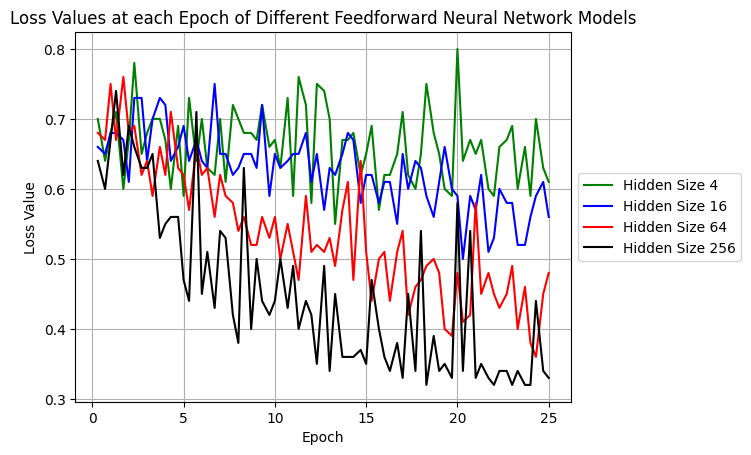

In [82]:
plt.plot(epoch_df['epoch_value'], epoch_df['loss_value_4'], color = "green", label = "Hidden Size 4")

#plt.plot(epoch_df['epoch_value'], epoch_df['loss_value_8'], color = "yellow", label = "hidden size 8")

plt.plot(epoch_df['epoch_value'], epoch_df['loss_value_16'], color = "blue", label = "Hidden Size 16")

#plt.plot(epoch_df['epoch_value'], epoch_df['loss_values_32'], color = "purple", label = "hidden size 32")

plt.plot(epoch_df['epoch_value'], epoch_df['loss_value_64'], color = "red", label = "Hidden Size 64")

#plt.plot(epoch_df['epoch_value'], epoch_df['loss_values_128'], color = "orange", label = "hidden size 128")

plt.plot(epoch_df['epoch_value'], epoch_df['loss_values_256'], color = "black", label = "Hidden Size 256")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Loss Values at each Epoch of Different Feedforward Neural Network Models')

plt.xlabel('Epoch')

plt.ylabel('Loss Value')

plt.grid(True)

plt.show()